In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from datetime import datetime
import sqlite3
import pysentiment2 as ps

# Librerías para el procesamiento de lenguaje natural
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Librerías para el modelado
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Keras y TensorFlow para construir la CNN
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
# hp.choice() para elegir entre una lista de opciones
from keras_tuner import HyperModel as hp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D, 
                                     Dense, Dropout, concatenate, Attention, 
                                     LayerNormalization, LSTM, Bidirectional, BatchNormalization, 
                                     GRU)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [2]:
news_df_or = pd.read_csv('../data/processed/financial_news_clean.csv')

In [3]:
news_df_or.head()

,id,title,url,published_date,company_id,content,description,ticker,dateHour,cleaned_text,tokens,len_tokens,sentiment_label_ps,score_ps,sentiment_score_ps,sentiment_label_finbert,sentiment_score_finbert
0,15582,Singing Machine and Stingray Unveil New Karaok...,https://www.globenewswire.com/news-release/202...,2024-01-08 13:00:00,16,Stingray and Singing Machine partner to debut ...,Stingray and Singing Machine partner to debut ...,MICS,2024-01-08 13,stingray singing machine partner debut major n...,"['stingray', 'singing', 'machine', 'partner', ...",651,positive,25,0.666667,neutral,0.857830
1,15567,Singing Machine Announces New Partnership with...,https://www.globenewswire.com/news-release/202...,2023-06-29 12:00:00,16,"Fort Lauderdale, FL, June 29, 2023 (GLOBE NEWS...","Fort Lauderdale, FL, June 29, 2023 (GLOBE NE...",MICS,2023-06-29 12,fort lauderdale fl june globe newswire singing...,"['fort', 'lauderdale', 'fl', 'june', 'globe', ...",464,positive,17,0.619048,neutral,0.752502
2,15569,Singing Machine Announces Updated Time for Ear...,https://www.globenewswire.com/news-release/202...,2023-07-13 20:05:00,16,"Fort Lauderdale, FL, July 13, 2023 (GLOBE NEWS...","Fort Lauderdale, FL, July 13, 2023 (GLOBE NE...",MICS,2023-07-13 20,fort lauderdale fl july globe newswire singing...,"['fort', 'lauderdale', 'fl', 'july', 'globe', ...",294,negative,4,-0.142857,neutral,0.915010
3,15570,Singing Machine Announces Financial Results fo...,https://www.globenewswire.com/news-release/202...,2023-07-14 20:05:00,16,"Fort Lauderdale, FL, July 14, 2023 (GLOBE NEWS...","Fort Lauderdale, FL, July 14, 2023 (GLOBE NE...",MICS,2023-07-14 20,fort lauderdale fl july globe newswire singing...,"['fort', 'lauderdale', 'fl', 'july', 'globe', ...",1232,negative,31,-0.192308,neutral,0.834538
4,15572,Why Lixte Biotechnology Shares Are Trading Low...,https://www.benzinga.com/news/23/07/33271322/w...,2023-07-18 17:00:51,16,"Gainers Pieris Pharmaceuticals, Inc. PIRS gain...","Gainers\n\nPieris Pharmaceuticals, Inc. (NASDA...",MICS,2023-07-18 17,gainer pieris pharmaceutical inc pirs gained c...,"['gainer', 'pieris', 'pharmaceutical', 'inc', ...",478,negative,15,-0.428571,neutral,0.674966


In [4]:
news_df = news_df_or[['cleaned_text', 'sentiment_label_ps']].copy()
news_df.columns = ['cleaned_text', 'sentiment_label']
news_df['sentiment_label'] = news_df['sentiment_label'].map({'positive': 2, 'neutral': 1, 'negative': 0})

In [5]:
news_df.head()

,cleaned_text,sentiment_label
0,stingray singing machine partner debut major n...,2
1,fort lauderdale fl june globe newswire singing...,2
2,fort lauderdale fl july globe newswire singing...,0
3,fort lauderdale fl july globe newswire singing...,0
4,gainer pieris pharmaceutical inc pirs gained c...,0


In [6]:
X = news_df['cleaned_text'].values
y = news_df['sentiment_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,       # 20% para test, ajusta a tu conveniencia
    random_state=42,
    stratify=y           # Estratifica para mantener proporciones
)

In [7]:
# Hiperparámetros
vocab_size = 10000    # máximo número de palabras en el vocabulario
max_length = 50       # longitud máxima de cada secuencia (ajusta según tu dataset)

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convertir texto a secuencias
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences  = tokenizer.texts_to_sequences(X_test)

# Rellenar/padding de secuencias
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded  = pad_sequences(test_sequences,  maxlen=max_length, padding='post', truncating='post')

In [8]:
embedding_dim = 128  # dimensión de embedding

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 clases: [negativo, neutro, positivo]

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/opt/miniconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-02-27 23:57:36.082191: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-02-27 23:57:36.082228: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-02-27 23:57:36.082235: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-02-27 23:57:36.082255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-27 23:57:36.082271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 10
batch_size = 16

history = model.fit(
    X_train_padded, 
    y_train, 
    validation_split=0.2,  # 20% del train para validación
    epochs=epochs, 
    batch_size=batch_size
)

Epoch 1/10


2025-02-27 23:57:46.744034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


552/552 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5011 - loss: 0.9728 - val_accuracy: 0.6861 - val_loss: 0.7569
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7689 - loss: 0.6235 - val_accuracy: 0.7278 - val_loss: 0.6828
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8883 - loss: 0.3415 - val_accuracy: 0.7101 - val_loss: 0.7306
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9513 - loss: 0.1726 - val_accuracy: 0.7115 - val_loss: 0.8920
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9796 - loss: 0.0862 - val_accuracy: 0.6984 - val_loss: 1.1359
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9863 - loss: 0.0545 - val_accuracy: 0.6916 - val_loss: 1.3369
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9903 - loss: 0.0379 - val_accuracy: 0.6907 - val_loss: 1.4549
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9913 - loss: 0.0320 - val_accuracy: 0.694

In [10]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Loss en Test: {loss:.4f}")
print(f"Accuracy en Test: {accuracy:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6714 - loss: 2.1498
Loss en Test: 2.0493
Accuracy en Test: 0.6815


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.7378    0.5326    0.6186       935
           1     0.6902    0.6828    0.6865       744
           2     0.6486    0.8094    0.7202      1081

    accuracy                         0.6815      2760
   macro avg     0.6922    0.6750    0.6751      2760
weighted avg     0.6900    0.6815    0.6767      2760

[[498 123 314]
 [ 76 508 160]
 [101 105 875]]


## Modelo con embedings Aleatorios

In [12]:
# --- Tokenización ---
vocab_size = 10000
max_length = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded  = pad_sequences(X_test_seq,  maxlen=max_length, padding='post', truncating='post')

# --- Construcción del modelo ---
embedding_dim = 64  # Embeddings aleatorios

# Entrada
inputs = Input(shape=(max_length,), name="input_tokens")

# Embedding desde cero
embedding = Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=max_length,
                      trainable=True)(inputs)

# Varias capas Conv1D
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(embedding)
x = Dropout(0.3)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Combinar CNN con capa bidireccional LSTM
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dropout(0.1)(x)

x = GlobalMaxPooling1D()(x)

# Capas densas con regularización
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.1)(x)

outputs = Dense(3, activation='softmax')(x)

model_scratch = Model(inputs=inputs, outputs=outputs)
model_scratch.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_scratch.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

/opt/miniconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 772,483 (2.95 MB)

 Trainable params: 772,227 (2.95 MB)

 Non-trainable params: 256 (1.00 KB)

In [13]:
# --- Entrenamiento ---
history = model_scratch.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# guardar modelo
joblib.dump(model_scratch, '../models/model_scratch.pkl')

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.4885 - loss: 0.9944 - val_accuracy: 0.6168 - val_loss: 1.0215
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.7244 - loss: 0.6909 - val_accuracy: 0.7151 - val_loss: 0.7854
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.8497 - loss: 0.4415 - val_accuracy: 0.7160 - val_loss: 0.7033
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.8925 - loss: 0.3240 - val_accuracy: 0.7092 - val_loss: 0.7562
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9223 - loss: 0.2387 - val_accuracy: 0.6920 - val_loss: 0.9473
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.9412 - loss: 0.1709 - val_accuracy: 0.6744 - val_loss: 1.1709
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9623 - loss: 0.1299 - val_accuracy: 0.6798 - val_loss: 1.1633
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9709 - loss: 0

['../models/model_scratch.pkl']

In [14]:
# --- Evaluación ---
scratch_loss, scratch_acc = model_scratch.evaluate(X_test_padded, y_test, verbose=0)
print(f"[SCRATCH+Attention] Test Loss: {scratch_loss:.4f}, Test Acc: {scratch_acc:.4f}")

# --- Predicciones ---
y_pred_probs = model_scratch.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))


#  --- Precisión y Recall ---
scratch_precision = Precision()
scratch_recall = Recall()

scratch_precision.update_state(y_test, y_pred)
scratch_recall.update_state(y_test, y_pred)

print(f"Precision: {scratch_precision.result().numpy():.4f}")
print(f"Recall: {scratch_recall.result().numpy():.4f}")
print(f"F1-Score: {2 * (scratch_precision.result().numpy() * scratch_recall.result().numpy()) / (scratch_precision.result().numpy() + scratch_recall.result().numpy()):.4f}")

[SCRATCH+Attention] Test Loss: 0.7283, Test Acc: 0.6989
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
              precision    recall  f1-score   support

           0     0.6871    0.6364    0.6607       935
           1     0.6876    0.7513    0.7180       744
           2     0.7169    0.7169    0.7169      1081

    accuracy                         0.6989      2760
   macro avg     0.6972    0.7015    0.6986      2760
weighted avg     0.6989    0.6989    0.6982      2760

[[595 140 200]
 [ 79 559 106]
 [192 114 775]]
Precision: 0.8205
Recall: 0.8515
F1-Score: 0.8357


In [15]:
# Guardar metriacas
metrics = {
    'Modelo': 'CNN + Embed aleatorios',
    'Accuracy': scratch_acc,
    'Loss': scratch_loss,
    'Precision': scratch_precision.result().numpy(),
    'Recall': scratch_recall.result().numpy(),
    'F1-Score': 2 * (scratch_precision.result().numpy() * scratch_recall.result().numpy()) / (scratch_precision.result().numpy() + scratch_recall.result().numpy())
}

# classification_report = classification_report(y_test, y_pred, output_dict=True)
# df_classification_report = pd.DataFrame(classification_report).transpose()
# df_classification_report = df_classification_report.reset_index()
# df_classification_report = df_classification_report.rename(columns={'index': 'metric'})
# df_classification_report['Modelo'] = 'Modelo + Embed aleatorios'
# print(df_classification_report)

metrics_df = pd.DataFrame(metrics, index=[0])
metrics_df

,Modelo,Accuracy,Loss,Precision,Recall,F1-Score
0,CNN + Embed aleatorios,0.698913,0.728337,0.820486,0.851507,0.835709


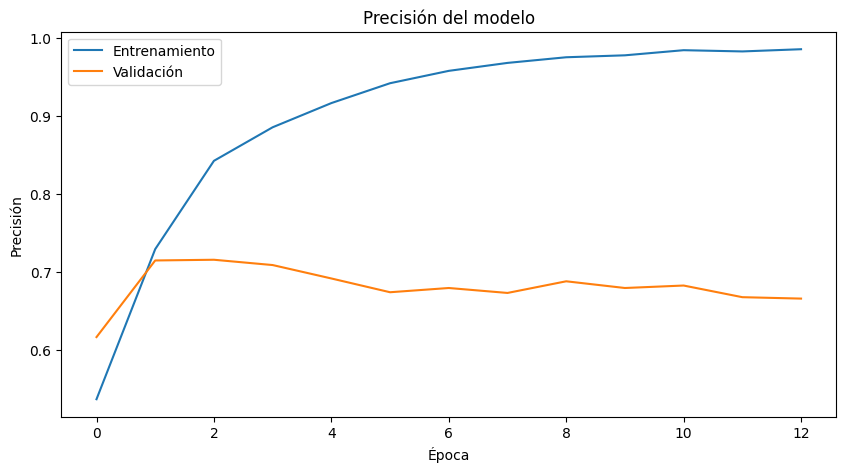

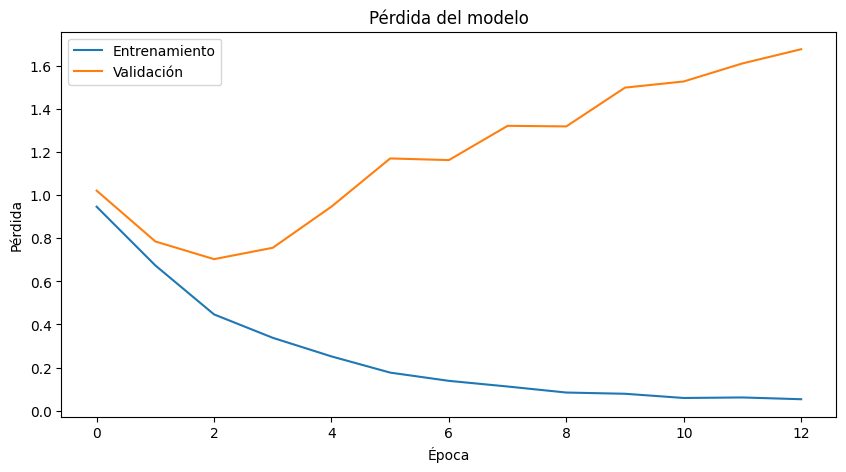

In [16]:
# Gráfico de precisión
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

# Gráfico de pérdida
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()

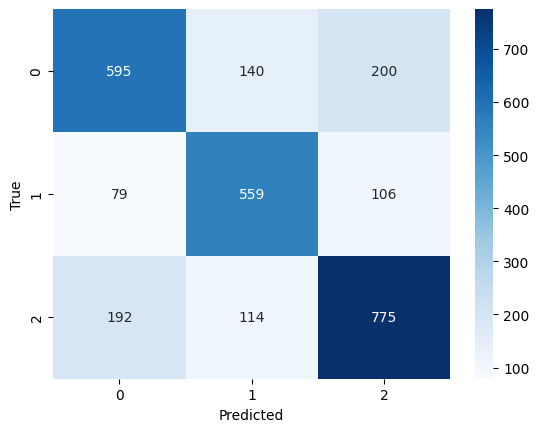

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo con embedings Glove

In [24]:
# --- Tokenización ---
vocab_size = 5000
max_length = 20
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded  = pad_sequences(X_test_seq,  maxlen=max_length, padding='post', truncating='post')

# --- Cargar GloVe ---
glove_path = '../data/external/.vector_cache/glove.6B.100d.txt'  # Ajusta a tu ruta
embedding_dim = 100                      # Debe coincidir con glove.6B.100d

print("Cargando embeddings GloVe...")
embeddings_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Crear la embedding_matrix para nuestro vocabulario
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# --- Construcción del modelo (API Funcional) ---
inputs = Input(shape=(max_length,), name="input_tokens")

# Capa Embedding inicializada con GloVe
embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_length,
    weights=[embedding_matrix],
    trainable=True  # O True si quieres "fine-tuning" de GloVe
)(inputs)

# Varias capas Conv1D con diferentes kernels
x1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(embedding)
x2 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(embedding)
x3 = Conv1D(filters=128, kernel_size=7, activation='relu', padding='same')(embedding)
x = concatenate([x1, x2, x3])

# Capa bidireccional y atención
x = Bidirectional(LSTM(64, return_sequences=True))(x)
attention = Attention()([x, x])  # Self-attention
x = GlobalMaxPooling1D()(attention)

# Regularización en capas densas
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)

# Construir modelo
model_glove = Model(inputs=inputs, outputs=outputs)
model_glove.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_glove.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Cargando embeddings GloVe...


/opt/miniconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_tokens        │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 100)   │    500,000 │ input_tokens[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 128)   │     38,528 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20, 128)   │     64,128 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20, 128)   │     89,728 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20, 384)   │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 128)   │    229,888 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 128)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        195 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 947,235 (3.61 MB)

 Trainable params: 947,235 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# --- Entrenamiento ---
history_glove = model_glove.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# guardar modelo
joblib.dump(model_glove, '../models/model_glove.pkl')

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.4912 - loss: 1.0201 - val_accuracy: 0.6313 - val_loss: 0.8607
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.6436 - loss: 0.8298 - val_accuracy: 0.6436 - val_loss: 0.8116
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.7152 - loss: 0.6986 - val_accuracy: 0.6843 - val_loss: 0.7759
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.7769 - loss: 0.5661 - val_accuracy: 0.6735 - val_loss: 0.8355
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.8331 - loss: 0.4628 - val_accuracy: 0.6789 - val_loss: 0.8690
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.8701 - loss: 0.3544 - val_accuracy: 0.6481 - val_loss: 1.0119
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.9095 - loss: 0.2744 - val_accuracy: 0.6354 - val_loss: 1.2743
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.9294 - loss: 0.2

['../models/model_glove.pkl']

In [26]:
# --- Evaluación ---
glove_loss, glove_acc = model_glove.evaluate(X_test_padded, y_test)
print(f"[GLOVE+Attention] Test Loss: {glove_loss:.4f}, Test Acc: {glove_acc:.4f}")

# --- Predicciones ---
y_pred_probs = model_glove.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

#  --- Precisión y Recall ---
glove_precision = Precision()
glove_recall = Recall()

glove_precision.update_state(y_test, y_pred)
glove_recall.update_state(y_test, y_pred)

print(f"Precision: {glove_precision.result().numpy():.4f}")
print(f"Recall: {glove_recall.result().numpy():.4f}")
print(f"F1-Score: {2 * (glove_precision.result().numpy() * glove_recall.result().numpy()) / (glove_precision.result().numpy() + glove_recall.result().numpy()):.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6573 - loss: 0.7963
[GLOVE+Attention] Test Loss: 0.7953, Test Acc: 0.6601
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
              precision    recall  f1-score   support

           0     0.6417    0.5594    0.5977       935
           1     0.7359    0.6331    0.6806       744
           2     0.6345    0.7660    0.6940      1081

    accuracy                         0.6601      2760
   macro avg     0.6707    0.6528    0.6575      2760
weighted avg     0.6643    0.6601    0.6578      2760

[[523 104 308]
 [104 471 169]
 [188  65 828]]
Precision: 0.7882
Recall: 0.8400
F1-Score: 0.8133


In [27]:
# Guardar metriacas
metrics_glove = {
    'Modelo': 'CNN + Embed GloVe',
    'Accuracy': glove_acc,
    'Loss': glove_loss,
    'Precision': glove_precision.result().numpy(),
    'Recall': glove_recall.result().numpy(),
    'F1-Score': 2 * (glove_precision.result().numpy() * glove_recall.result().numpy()) / (glove_precision.result().numpy() + glove_recall.result().numpy())
}

# classification_report = classification_report(y_test, y_pred, output_dict=True)
# df_classification_report = pd.DataFrame(classification_report).transpose()
# df_classification_report = df_classification_report.reset_index()
# df_classification_report = df_classification_report.rename(columns={'index': 'metric'})
# df_classification_report['Modelo'] = 'Modelo + Embed GloVe'
# print(df_classification_report)

metrics_glove

{'Modelo': 'CNN + Embed GloVe',
 'Accuracy': 0.6601449251174927,
 'Loss': 0.7952858805656433,
 'Precision': 0.7881748,
 'Recall': 0.84,
 'F1-Score': 0.81326258665175}

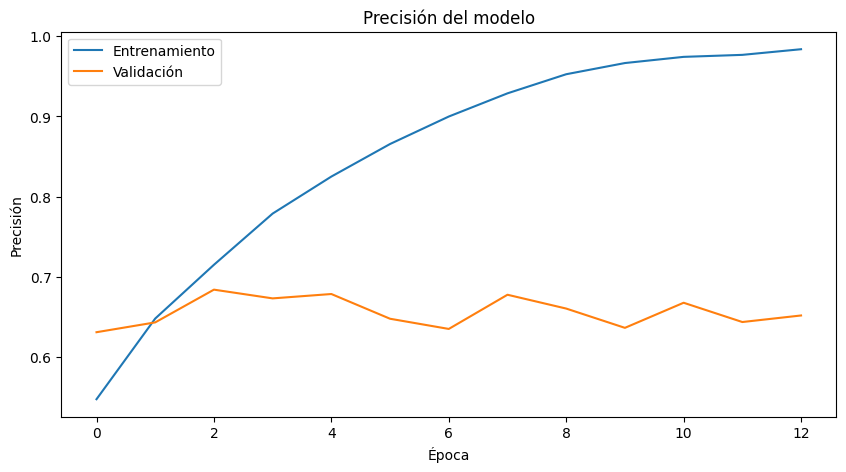

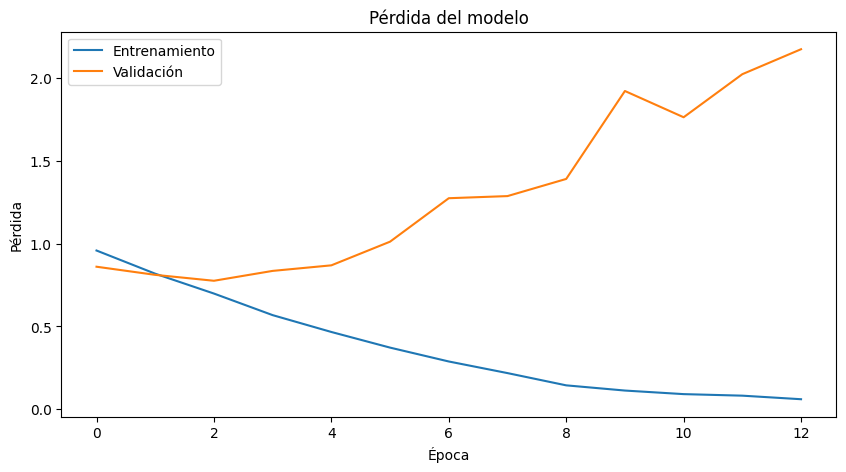

In [28]:
# Gráfico de precisión
plt.figure(figsize=(10,5))
plt.plot(history_glove.history['accuracy'], label='Entrenamiento')
plt.plot(history_glove.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

# Gráfico de pérdida
plt.figure(figsize=(10,5))
plt.plot(history_glove.history['loss'], label='Entrenamiento')
plt.plot(history_glove.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()

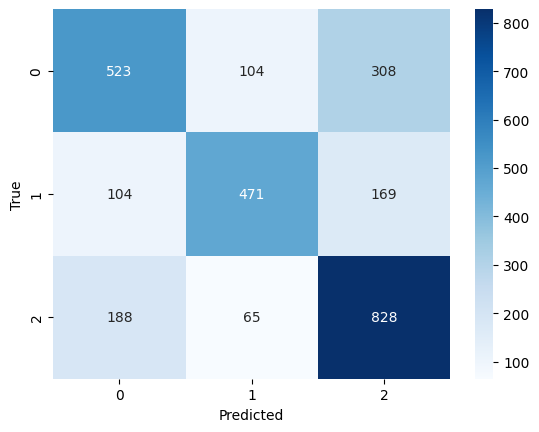

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo con Embedding FastText

In [31]:
# --- Tokenización ---
vocab_size = 5000
max_length = 20
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded  = pad_sequences(X_test_seq,  maxlen=max_length, padding='post', truncating='post')

# --- Cargar FastText ---
fasttext_path = '../data/external/cc.en.300/cc.en.300.vec'  # Ajusta a tu ruta
embedding_dim = 300                      # Debe coincidir con tus vectores FastText

print("Cargando embeddings FastText...")
embeddings_index = {}
with open(fasttext_path, encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# --- Construcción del modelo ---
inputs = Input(shape=(max_length,), name="input_tokens")

embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_length,
    weights=[embedding_matrix],
    trainable=True  # o True si quieres fine-tuning
)(inputs)

# Varias convoluciones con kernels de diferentes tamaños
x1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(embedding)
x2 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(embedding)
x3 = Conv1D(filters=128, kernel_size=7, activation='relu', padding='same')(embedding)
x = concatenate([x1, x2, x3])

# Bidireccional GRU
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = BatchNormalization()(x)

# Capa de atención
attention = Attention()([x, x])
x = GlobalMaxPooling1D()(attention)

# Capas densas
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.2)(x)

# Capa de salida
outputs = Dense(3, activation='softmax')(x)

# Construcción y compilación del modelo
model_fasttext = Model(inputs=inputs, outputs=outputs)
model_fasttext.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_fasttext.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Cargando embeddings FastText...


/opt/miniconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_tokens        │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 20, 300)   │  1,500,000 │ input_tokens[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 20, 128)   │    115,328 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 20, 128)   │    192,128 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 20, 128)   │    268,928 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20, 384)   │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 20, 128)   │    172,800 │ concatenate_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 128)   │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 20, 128)   │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        195 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,274,659 (8.68 MB)

 Trainable params: 2,274,403 (8.68 MB)

 Non-trainable params: 256 (1.00 KB)

In [32]:
# --- Entrenamiento ---
history_fasttext = model_fasttext.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# guardar modelo
joblib.dump(model_fasttext, '../models/model_fasttext.pkl')

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.4774 - loss: 1.0795 - val_accuracy: 0.5942 - val_loss: 1.0325
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.6827 - loss: 0.7604 - val_accuracy: 0.6676 - val_loss: 0.8554
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.7839 - loss: 0.5525 - val_accuracy: 0.6780 - val_loss: 0.8012
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.8470 - loss: 0.4191 - val_accuracy: 0.6341 - val_loss: 0.9552
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.8909 - loss: 0.3112 - val_accuracy: 0.6526 - val_loss: 1.0394
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.9335 - loss: 0.2124 - val_accuracy: 0.6522 - val_loss: 1.4650
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9489 - loss: 0.1612 - val_accuracy: 0.6264 - val_loss: 1.6630
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9679 - loss: 0

['../models/model_fasttext.pkl']

In [33]:
# --- Evaluación ---
fasttext_loss, fasttext_acc = model_fasttext.evaluate(X_test_padded, y_test)
print(f"[FASTTEXT+Attention] Test Loss: {fasttext_loss:.4f}, Test Acc: {fasttext_acc:.4f}")

# --- Predicciones ---
y_pred_probs = model_fasttext.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

#  --- Precisión y Recall ---
fasttext_precision = Precision()
fasttext_recall = Recall()

fasttext_precision.update_state(y_test, y_pred)
fasttext_recall.update_state(y_test, y_pred)

print(f"Precision: {fasttext_precision.result().numpy():.4f}")
print(f"Recall: {fasttext_recall.result().numpy():.4f}")
print(f"F1-Score: {2 * (fasttext_precision.result().numpy() * fasttext_recall.result().numpy()) / (fasttext_precision.result().numpy() + fasttext_recall.result().numpy()):.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6677 - loss: 0.7852
[FASTTEXT+Attention] Test Loss: 0.7772, Test Acc: 0.6743
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
              precision    recall  f1-score   support

           0     0.6498    0.6310    0.6403       935
           1     0.7416    0.6210    0.6759       744
           2     0.6583    0.7484    0.7004      1081

    accuracy                         0.6743      2760
   macro avg     0.6832    0.6668    0.6722      2760
weighted avg     0.6778    0.6743    0.6734      2760

[[590  80 265]
 [127 462 155]
 [191  81 809]]
Precision: 0.8137
Recall: 0.8258
F1-Score: 0.8197


In [34]:
# Guardar metriacas
metrics_fasttext = {
    'Modelo': 'CNN + Embed FastText',
    'Accuracy': fasttext_acc,
    'Loss': fasttext_loss,
    'Precision': fasttext_precision.result().numpy(),
    'Recall': fasttext_recall.result().numpy(),
    'F1-Score': 2 * (fasttext_precision.result().numpy() * fasttext_recall.result().numpy()) / (fasttext_precision.result().numpy() + fasttext_recall.result().numpy())
}

metrics_fasttext

{'Modelo': 'CNN + Embed FastText',
 'Accuracy': 0.6742753386497498,
 'Loss': 0.777201235294342,
 'Precision': 0.8137149,
 'Recall': 0.82575345,
 'F1-Score': 0.81968998734663}

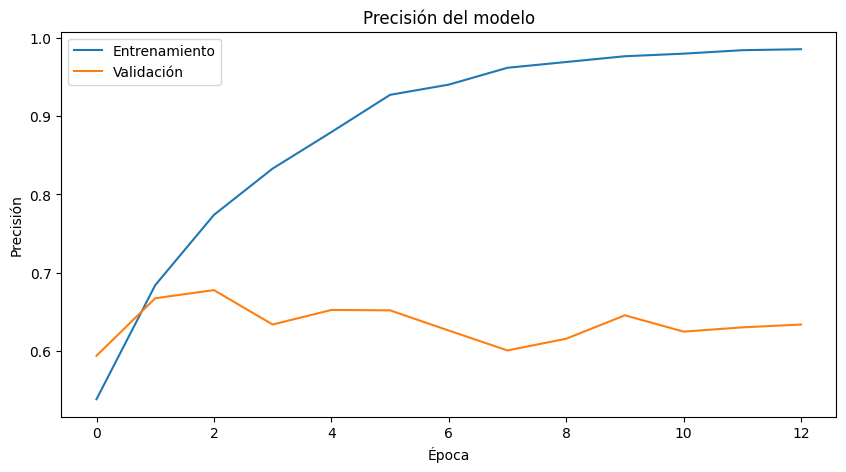

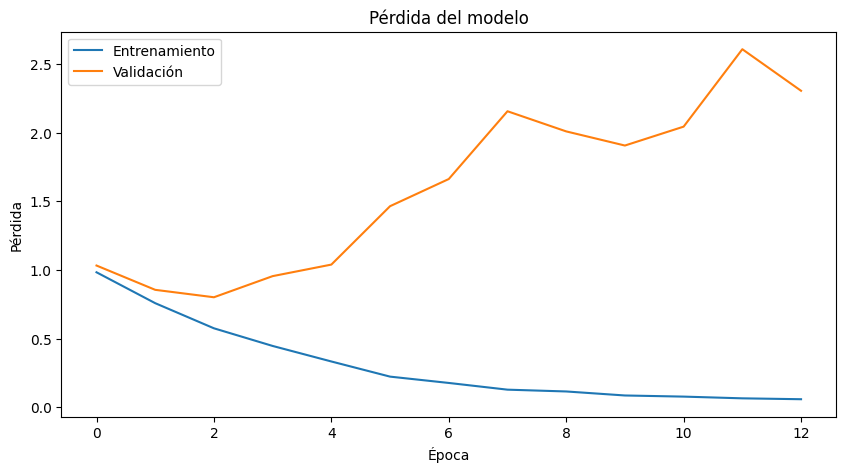

In [35]:
# Gráfico de precisión
plt.figure(figsize=(10,5))
plt.plot(history_fasttext.history['accuracy'], label='Entrenamiento')
plt.plot(history_fasttext.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

# Gráfico de pérdida
plt.figure(figsize=(10,5))
plt.plot(history_fasttext.history['loss'], label='Entrenamiento')
plt.plot(history_fasttext.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()

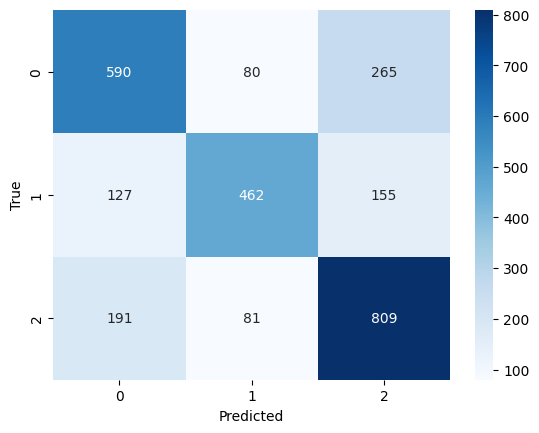

In [36]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [38]:
final_metrics = [metrics, metrics_glove, metrics_fasttext]
df_final_metrics = pd.DataFrame(final_metrics)
df_final_metrics.to_csv('../data/processed/final_metrics.csv', index=False)

In [39]:
df_final_metrics

,Modelo,Accuracy,Loss,Precision,Recall,F1-Score
0,CNN + Embed aleatorios,0.698913,0.728337,0.820486,0.851507,0.835709
1,CNN + Embed GloVe,0.660145,0.795286,0.788175,0.840000,0.813263
2,CNN + Embed FastText,0.674275,0.777201,0.813715,0.825753,0.819690
